# Final Project 

### Fold Change method

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read Data Healthy and Cancer
df_h = pd.read_table("Project Data/lusc-rsem-fpkm-tcga_paired.txt", delimiter="\t")
df_t = pd.read_table("Project Data/lusc-rsem-fpkm-tcga-t_paired.txt", delimiter="\t")

# Filter Data from Zero values( drop if count of zeros exceeds half of samples )
df_h =df_h[(df_h == 0).sum(1) < 25]
df_t =df_t[(df_t == 0).sum(1) < 25]
print(df_h.shape)
print(df_t.shape)

# Plot a histogram for healthy samples in order to check that it is not logged to the base 2
#for i in range(2,10):
#    plt.hist(df_h.iloc[i,2:].values, bins=50)
#    plt.show()

# Claculate the mean for each gene
df_h['mean'] = df_h.iloc[:,2:].mean(axis=1)
df_t['mean'] = df_t.iloc[:,2:].mean(axis=1)
print(df_h.shape)
print(df_t.shape)

# create 2 dataframes which includes the gene names and means initially
df = pd.DataFrame()
df["Hugo_Symbol"]=df_t["Hugo_Symbol"]
df["meant"]=df_t["mean"]

df2 = pd.DataFrame()
df2["Hugo_Symbol"]=df_h["Hugo_Symbol"]
df2["meanh"]=df_h["mean"]
print(df.shape)
print(df2.shape)

# Merge the 2 dataframes inorder to get the intersection between them (Which was filtered from Zeros)
df2 = df2.merge(df,"inner",on = "Hugo_Symbol")
print(df2.shape)

# Calculate the FC value for each gene using thier means
df2["FC"] = np.log2(df2['meant']/df2['meanh'])

fold_volc = pd.DataFrame()
fold_volc = df2
fold_volc = fold_volc.drop(["meanh","meant"],axis=1)
# Using threshold 2.2765 inorder to get the most 2000 DEGs in the data
df2 = df2[df2["FC"].abs()>2.2765]
print(df2.shape)

# create a data fram includes the DEGs and their samples (both healthy and tumor in same dataframe)
df_DEGs = pd.DataFrame()
healthy = pd.read_csv('Project Data/lusc-rsem-fpkm-tcga_paired.txt', sep='\t')
cancer = pd.read_csv('Project Data/lusc-rsem-fpkm-tcga-t_paired.txt', sep='\t')
for i in range(len(healthy.columns)):
    if i ==0 or i == 1:
        continue
    else:
        healthy.rename(columns={healthy.columns[i] : healthy.columns[i]+"h"}, inplace=True)
        cancer.rename(columns={cancer.columns[i] : cancer.columns[i]+"t"}, inplace=True)
gsmea= pd.DataFrame()
gsmea["Hugo_Symbol"] = df2["Hugo_Symbol"]
gsmea = gsmea.merge(healthy,"inner",on="Hugo_Symbol")
gsmea["Entrez_Gene_Id"] = "na"
gsmea.rename(columns={"Entrez_Gene_Id" : "DESCRIPTION"}, inplace=True)

# merge normal and tumor samples in one dataframe
gsmea = gsmea.merge(cancer,"inner",on="Hugo_Symbol")
gsmea = gsmea.drop(["Entrez_Gene_Id"],axis=1)
gsmea.rename(columns={"Hugo_Symbol" : "NAME"}, inplace=True)
print(gsmea.shape)

# Export .txt file wich can be used as an input for GSEA SoftWare
#gsmea.to_csv("fold_change-ve.txt",sep="\t",index=False)





(17626, 52)
(17717, 52)
(17626, 53)
(17717, 53)
(17717, 2)
(17626, 2)
(17275, 3)
(2000, 4)
(2000, 102)


### hypothesis testing

In [34]:
import pandas as pd
from scipy.stats import ttest_rel,ttest_ind,wilcoxon,mannwhitneyu
from statsmodels.stats.multitest import multipletests

#read csv files and create DataFrames
healthy = pd.read_csv('Project Data/lusc-rsem-fpkm-tcga_paired.txt', sep='\t')
cancer = pd.read_csv('Project Data/lusc-rsem-fpkm-tcga-t_paired.txt', sep='\t')
print(healthy.shape)
print(cancer.shape)
#remove rows with many zeros
healthy =healthy[(healthy == 0).sum(1) < 25]
cancer =cancer[(cancer == 0).sum(1) < 25]
print(healthy.shape)
print(cancer.shape)
intersected_genes = set(healthy['Hugo_Symbol']).intersection(set(cancer['Hugo_Symbol']))
healthy =healthy[healthy['Hugo_Symbol'].isin(intersected_genes)]
cancer =cancer[cancer['Hugo_Symbol'].isin(intersected_genes)]
print(healthy.shape)
print(cancer.shape)


from scipy.stats import shapiro
healthy_nonNormal =0
cancer_nonNormal =0
for i in range(cancer.shape[0]):
    stat_h,p_h = shapiro(healthy.iloc[i,2:])
    stat_c,p_c = shapiro(cancer.iloc[i,2:])
    if p_h < 0.05:
        healthy_nonNormal+=1
    if p_c < 0.05:
        cancer_nonNormal+=1
print(healthy_nonNormal,cancer_nonNormal)



rel_val =[]
ind_val =[]
for i in range(cancer.shape[0]):
    #to make Samples paired
    p_val_rel = wilcoxon(healthy.iloc[i,2:].to_list(), cancer.iloc[i,2:].to_list()).pvalue
    #to make Samples indpendant
    p_val_ind = mannwhitneyu(healthy.iloc[i,2:].to_list(), cancer.iloc[i,2:].to_list()).pvalue 
    #append p values to lists
    rel_val.append(p_val_rel)
    ind_val.append(p_val_ind)

#Apply the FDR multiple tests correction method
p_relval_fdr = multipletests(rel_val, alpha=0.05, method='fdr_bh')[1]
p_indval_fdr = multipletests(ind_val, alpha=0.05, method='fdr_bh')[1]

#get the list of DEGs before and after the FDR correction for Samples paired
sign_paired = pd.DataFrame({'Hugo_Symbol':healthy['Hugo_Symbol'].tolist(), 'p_values':rel_val, 'p_values_fdr':p_relval_fdr})
sign_paired['significance:p_vlaue_fdr'] = sign_paired['p_values_fdr'].apply(lambda x: x < 0.05)
DEG_paired_fdr = sign_paired[sign_paired['significance:p_vlaue_fdr']== True]

sign_indg = pd.DataFrame({'Hugo_Symbol':healthy['Hugo_Symbol'].tolist(), 'p_values':ind_val, 'p_values_fdr':p_indval_fdr})
sign_indg['significance:p_vlaue_fdr'] = sign_indg['p_values_fdr'].apply(lambda x: x < 0.05)
DEG_ind_fdr = sign_indg[sign_indg['significance:p_vlaue_fdr']== True]



print(len(DEG_paired_fdr["Hugo_Symbol"]))
print(len(DEG_ind_fdr["Hugo_Symbol"]))



(19648, 52)
(19648, 52)
(17626, 52)
(17717, 52)
(17275, 52)
(17275, 52)
10281 15247
13141
13234


### Create file from the paired data (hypothesis testing only)as an input for the gsea software

In [35]:

gsmea= pd.DataFrame()
gsmea["Hugo_Symbol"] = DEG_paired_fdr["Hugo_Symbol"]
healthy = pd.read_csv('Project Data/lusc-rsem-fpkm-tcga_paired.txt', sep='\t')
cancer = pd.read_csv('Project Data/lusc-rsem-fpkm-tcga-t_paired.txt', sep='\t')
for i in range(len(healthy.columns)):
    if i ==0 or i == 1:
        continue
    else:
        healthy.rename(columns={healthy.columns[i] : healthy.columns[i]+"h"}, inplace=True)
        cancer.rename(columns={cancer.columns[i] : cancer.columns[i]+"t"}, inplace=True)
gsmea = gsmea.merge(healthy,"inner",on="Hugo_Symbol")
gsmea["Entrez_Gene_Id"] = "na"
gsmea.rename(columns={"Entrez_Gene_Id" : "DESCRIPTION"}, inplace=True)
gsmea = gsmea.merge(cancer,"inner",on="Hugo_Symbol")
gsmea = gsmea.drop(["Entrez_Gene_Id"],axis=1)
gsmea.rename(columns={"Hugo_Symbol" : "NAME"}, inplace=True)

#gsmea.to_csv("paired.txt",sep="\t",index=False)


### Volcano plot

  Hugo_Symbol    log2FC       p-value
0    HIST3H2A  2.416220  4.682766e-08
1       LIN7B  0.124599  2.756234e-01
2         LXN -0.821133  4.290195e-06
3      CNKSR2 -1.568083  5.630297e-08
4       SCML1 -0.270496  2.223009e-02
  Hugo_Symbol    log2FC       p-value
0    HIST3H2A  2.416220  1.558270e-10
1       LIN7B  0.124599  3.902897e-01
2         LXN -0.821133  4.312916e-07
3      CNKSR2 -1.568083  8.460026e-12
4       SCML1 -0.270496  6.603636e-03


findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


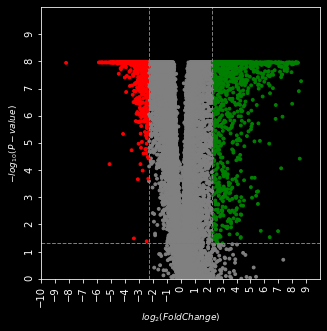

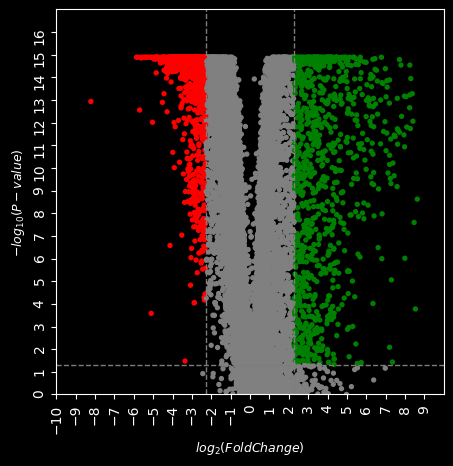

In [36]:
# create 2 dataframes for paired and independent
paired = sign_paired.drop(["p_values","significance:p_vlaue_fdr"],axis=1)
indep = sign_indg.drop(["p_values","significance:p_vlaue_fdr"],axis=1)

paired_volc = fold_volc.merge(paired,"inner",on="Hugo_Symbol")
indep_volc = fold_volc.merge(indep,"inner",on="Hugo_Symbol")
paired_volc.rename(columns={"FC" : "log2FC","p_values_fdr":"p-value"}, inplace=True)
indep_volc.rename(columns={"FC" : "log2FC","p_values_fdr":"p-value"}, inplace=True)

print(paired_volc.head(5))
print(indep_volc.head(5))
from bioinfokit import analys, visuz
visuz.GeneExpression.volcano(df=paired_volc, lfc="log2FC", pv="p-value",lfc_thr=[2.2765,2.2765],pv_thr=[0.05,0.05], theme='dark', 
    gstyle=2, sign_line=True, xlm=(-10,10,1), ylm=(0,10,1), axtickfontsize=10,
    axtickfontname='Verdana',show=True)

visuz.GeneExpression.volcano(df=indep_volc, lfc="log2FC", pv="p-value",lfc_thr=[2.2765,2.2765],pv_thr=[0.05,0.05], theme='dark', 
    gstyle=2, sign_line=True, xlm=(-10,10,1), ylm=(0,17,1), axtickfontsize=10,
    axtickfontname='Verdana',show=True)



### create txt file from volcano plot as an input to GSEA Software

In [6]:
volc_gsea= pd.DataFrame()
volc_gsea["Hugo_Symbol"]=paired_volc[paired_volc["p-value"]<0.05][paired_volc["log2FC"]<-2.2765]["Hugo_Symbol"]
healthy = pd.read_csv('Project Data/lusc-rsem-fpkm-tcga_paired.txt', sep='\t')
cancer = pd.read_csv('Project Data/lusc-rsem-fpkm-tcga-t_paired.txt', sep='\t')
for i in range(len(healthy.columns)):
    if i ==0 or i == 1:
        continue
    else:
        healthy.rename(columns={healthy.columns[i] : healthy.columns[i]+"h"}, inplace=True)
        cancer.rename(columns={cancer.columns[i] : cancer.columns[i]+"t"}, inplace=True)
volc_gsea = volc_gsea.merge(healthy,"inner",on="Hugo_Symbol")
volc_gsea["Entrez_Gene_Id"] = "na"
volc_gsea.rename(columns={"Entrez_Gene_Id" : "DESCRIPTION"}, inplace=True)
volc_gsea = volc_gsea.merge(cancer,"inner",on="Hugo_Symbol")
volc_gsea = volc_gsea.drop(["Entrez_Gene_Id"],axis=1)
volc_gsea.rename(columns={"Hugo_Symbol" : "NAME"}, inplace=True)
volc_gsea.shape
#volc_gsea.to_csv("volc_gsea_ve.txt",sep="\t",index=False)

/tmp/ipykernel_5953/422099486.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  volc_gsea["Hugo_Symbol"]=paired_volc[paired_volc["p-value"]<0.05][paired_volc["log2FC"]<-2.2765]["Hugo_Symbol"]


(899, 102)